In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
sys.path.append("../src")

## Dataset preparation

In [3]:
from src.common.utils import ObjectView
import yaml

with open("../config/ds/whiteld.yaml", "r") as f:
    cfg = ObjectView(yaml.safe_load(f))

cfg

{'matter': 'white',
 'method': 'clf',
 'lesions': True,
 'demo': True,
 'minmax': True,
 'batch_size': 1,
 'path': 'data',
 'gram': False,
 '_ipython_canary_method_should_not_exist_': {}}

In [4]:
from src.common.utils import ObjectView

import pandas as pd
import numpy as np

categoric_cols = ["Gender", "Stroke type", "Handedness"]
target_cols = ["Aphasia Type", "Severity"]
unusable_types = ["Semantic", "Acoustic-mnestic + Sensory", "Amnestic", "Other (neurodynamics)"]
severity_map = {
    "Very mild": 0.0,
    "Mild": 0.0,
    "Mild-moderate": 0.2,
    "Moderate": 0.4,
    "Moderate-severe": 0.6,
    "Severe": 0.8,
    "Very severe": 1.0
}


def get_tabular_data(matter, lesions=False, demo=False, method="clf", zscale=False, minmax=True, gram=False, path="data", **kwargs):
    kwargs = ObjectView(kwargs)
    kwargs.regtg = kwargs.get("regtg", "severity")
    
    wm = pd.read_excel(f"{path}/wm.xlsx").drop(columns=["N", "ID"]).reset_index()
    gm = pd.read_excel(f"{path}/gm.xlsx").drop(columns=["N", "ID"]).reset_index()
    demo_ = pd.read_excel(f"{path}/demo.xlsx").drop(columns=["N", "ID"]).reset_index()
    asa = pd.read_excel(f"{path}/asa.xlsx").drop(columns=["N", "ID"]).reset_index()

    if matter == "grey":
        df = gm
    elif matter == "white":
        df = wm
    else:
        df = pd.concat([gm, wm], axis=1)

    if lesions and matter == "grey":
        df.insert(1, "lesions", wm["Lesion volume"])
    elif not lesions and matter != "grey":
        df = df.drop(columns=["Lesion volume"])

    if demo:
        demo_["Handedness"] = demo_["Handedness"].fillna("left")
        demo_.replace("relearnt left", "left", inplace=True)
        demo_.replace("right/ambi", "ambi", inplace=True)
        demo_dummies = pd.get_dummies(demo_.drop(columns=target_cols))
        demo_dummies.loc[demo_dummies["Handedness_ambi"], ["Handedness_left", "Handedness_right"]] = True
        demo_dummies.loc[demo_dummies["Stroke type_hemorrhagic + ischemic"], ["Stroke type_hemorrhagic", "Stroke type_ischemic"]] = True
        demo_dummies.drop(columns=["Handedness_ambi", "Stroke type_hemorrhagic + ischemic", "Stroke type_aneurysm"], inplace=True)
        df = pd.concat([df, demo_dummies], axis=1)

    if method == "clf":
        usable = ~demo_["Aphasia Type"].isin(unusable_types)
        df, demo_ = df[usable], demo_[usable]
        target = pd.Categorical(demo_["Aphasia Type"]).codes
        n_classes = np.unique(target).shape[0]
    else:
        if kwargs.regtg == "severity":
            usable = demo_["Severity"].notna()
            df, demo_ = df[usable], demo_[usable]
            target = demo_["Severity"].map(severity_map)
        elif kwargs.regtg == "asa":
            usable = asa["ASA_after"].notna()
            df, demo_ = df[usable], demo_[usable]
            target = asa[usable]["ASA_after"]
        n_classes = None
    
    X = df.to_numpy(dtype=np.float32)
    if zscale:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    if minmax:
        if isinstance(zscale, list) or isinstance(zscale, tuple):
            lb, hb = zscale
        else:
            lb, hb = (0, 1)
        X = lb + (hb - lb) * (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
        if method == "reg" and kwargs.regtg == "asa":
            print(np.min(target), np.max(target))
            target = lb + (hb - lb) * (target - np.min(target)) / (np.max(target) - np.min(target))

    if gram:
        X = X @ X.T / X.shape[0]
        X = np.exp(X) / np.sum(np.exp(X), axis=1)

    return X, target, X.shape[1], n_classes, df.index.to_numpy()


In [5]:
cfg.path = "../data"
cfg.method = "reg"
cfg.regtg = "severity"
Xs, severity, _, _, svt_ids = get_tabular_data(**cfg)
print(Xs.shape, severity.shape)

cfg.regtg = "asa"
Xa, asa, _, _, asa_ids = get_tabular_data(**cfg)
print(Xa.shape, asa.shape)

(401, 48) (401,)
14.5 300.0
(269, 48) (269,)


In [6]:
import numpy as np


def map_asa(asa):
    asa = asa * 285.5 + 14.5
    if asa > 260:
        return 0
    elif asa > 220:
        return 0.2
    elif asa > 175:
        return 0.4
    elif asa > 130:
        return 0.6
    elif asa > 90:
        return 0.8
    else:
        return 1


asa_mapped = np.vectorize(map_asa, otypes=[float])(asa)

Text(0.5, 1.0, 'ASA mapped to severity')

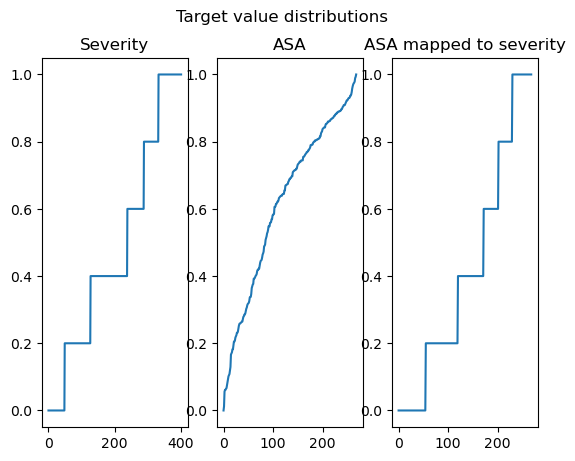

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Target value distributions")
ax1.plot(np.sort(severity))
ax1.set_title("Severity")
ax2.plot(np.sort(asa))
ax2.set_title("ASA")
ax3.plot(np.sort(asa_mapped))
ax3.set_title("ASA mapped to severity")

Text(0.5, 1.0, 'ASA-severity mapping')

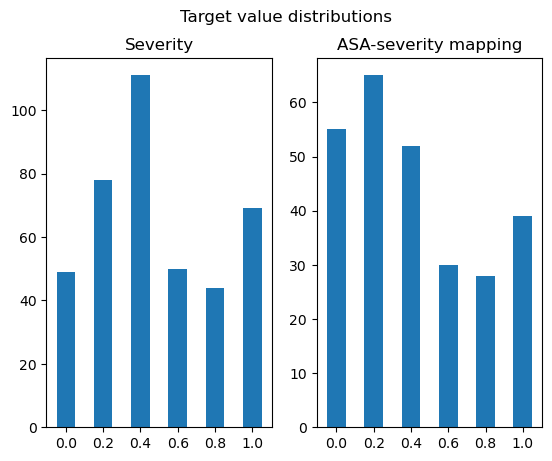

In [8]:
ys_unique, ys_counts = np.unique(severity, return_counts=True)
yas_unique, yas_counts = np.unique(asa_mapped, return_counts=True)

ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Target value distributions")
ax1.bar(ys_unique, ys_counts, width=0.1, tick_label=ticks)
ax1.set_title("Severity")
ax2.bar(yas_unique, yas_counts, width=0.1, tick_label=ticks)
ax2.set_title("ASA-severity mapping")

In [9]:
print("Number of patients not included for ASA:",  len(np.setdiff1d(svt_ids, asa_ids)))
print("Number of patients not included for severity:", len(np.setdiff1d(asa_ids, svt_ids)))

Number of patients not included for ASA: 133
Number of patients not included for severity: 1


In [10]:
common_ids = np.intersect1d(svt_ids, asa_ids)
len(common_ids)

268

Text(0.5, 1.0, 'ASA-severity mapping')

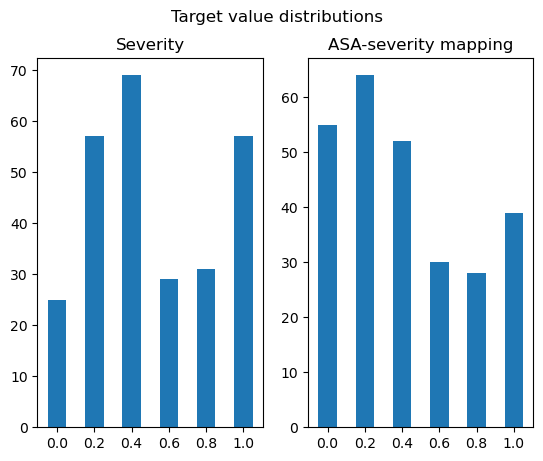

In [12]:
severity_common = severity[common_ids]
asa_mapped_common = pd.Series(asa_mapped)
asa_mapped_common.index = asa.index
asa_mapped_common = asa_mapped_common[common_ids]

ys_unique, ys_counts = np.unique(severity_common, return_counts=True)
yas_unique, yas_counts = np.unique(asa_mapped_common, return_counts=True)

ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Target value distributions")
ax1.bar(ys_unique, ys_counts, width=0.1, tick_label=ticks)
ax1.set_title("Severity")
ax2.bar(yas_unique, yas_counts, width=0.1, tick_label=ticks)
ax2.set_title("ASA-severity mapping")

In [17]:
severity_common = severity_common.to_numpy()
asa_mapped_common = asa_mapped_common.to_numpy()

In [49]:
def severity_diff(idx):
    return np.mean(np.abs(severity_common[idx]) - np.mean(asa_mapped_common[idx])) * 5

def severity_t_mean(idx):
    b_diff = severity_common[idx] - asa_mapped_common[idx]
    orig_mean = np.mean(severity_common) - np.mean(asa_mapped_common)
    se = (np.var(severity_common[idx]) + np.var(asa_mapped_common[idx])) / severity_common.shape[0]
    return np.mean(b_diff - orig_mean) / se ** 0.5

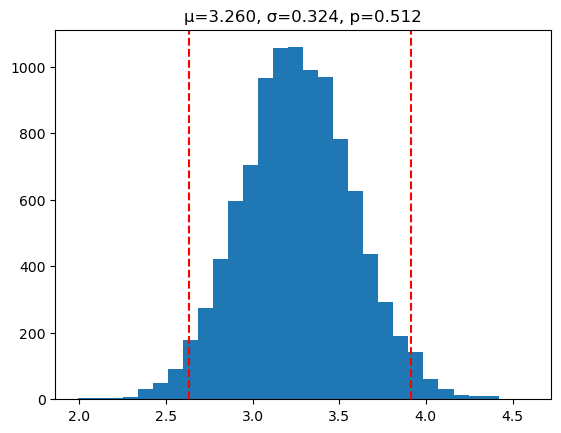

In [65]:
def get_t(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / x.shape[0])


def bootstrap_means(x, y, n_samples=10000):
    t = get_t(x, y)
    t_b = []
    for _ in range(n_samples):
        idx = np.random.randint(0, x.shape[0], x.shape[0])
        t_b.append(get_t(x[idx], y[idx]))
    p = np.where(np.array(t_b) >= t)[0].shape[0] / n_samples
    ci_low = np.percentile(t_b, [2.5])
    ci_high = np.percentile(t_b, [97.5])

    return t_b, p, ci_low, ci_high


def draw_bs(x, y):
    bst, p_value, ci_low, ci_high = bootstrap_means(x, y)
    plt.hist(bst, bins=30)
    plt.axvline(ci_low, color="r", ls="--")
    plt.axvline(ci_high, c="r", ls="--")
    plt.title(f"μ={np.mean(bst):.3f}, σ={np.std(bst):.3f}, p={p_value:.3f}")


draw_bs(severity_common, asa_mapped_common)

/var/folders/p0/zb5fdjs17y75059dngt863kw0000gn/T/ipykernel_88481/4149807541.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / x.shape[0])
/Users/mvkairov/mambaforge/envs/aphasia/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mvkairov/mambaforge/envs/aphasia/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/mvkairov/mambaforge/envs/aphasia/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mvkairov/mambaforge/envs/aphasia/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divi

ValueError: autodetected range of [nan, nan] is not finite

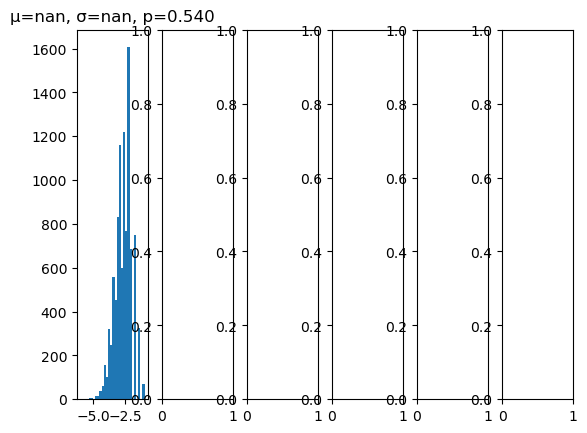

In [68]:
def draw_bs_classwise(x, y, classes=None):
    if classes is None:
        classes = list(range(6))
    
    fig, ax = plt.subplots(1, len(classes))
    fig.set_figwidth(20)
    for i in classes:
        idx = np.where(x == i / len(classes))
        bst, p_value, ci_low, ci_high = bootstrap_means(x[idx], y[idx])
        ax[i].hist(bst, bins=30)
        ax[i].axvline(ci_low, color="r", ls="--")
        ax[i].axvline(ci_high, c="r", ls="--")
        ax[i].title.set_text(f"μ={np.mean(bst):.3f}, σ={np.std(bst):.3f}, p={p_value:.3f}")


draw_bs_classwise(severity_common, asa_mapped_common)

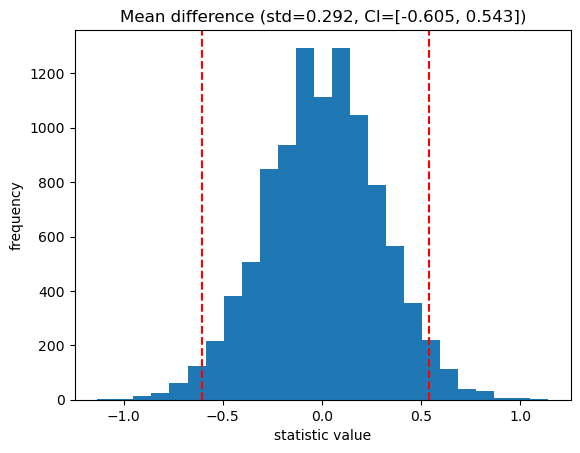

In [50]:
from scipy.stats import bootstrap
import numpy as np

rng = np.random.default_rng()
idx = np.arange(severity_common.shape[0])

res = bootstrap((idx,), severity_t_mean, confidence_level=0.95, random_state=rng)
ci_low, ci_high = res.confidence_interval

fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title(f'Mean difference (std={res.standard_error:.3f}, CI=[{ci_low:.3f}, {ci_high:.3f}])')
ax.axvline(ci_low, color="r", ls="--")
ax.axvline(ci_high, color="r", ls="--")
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

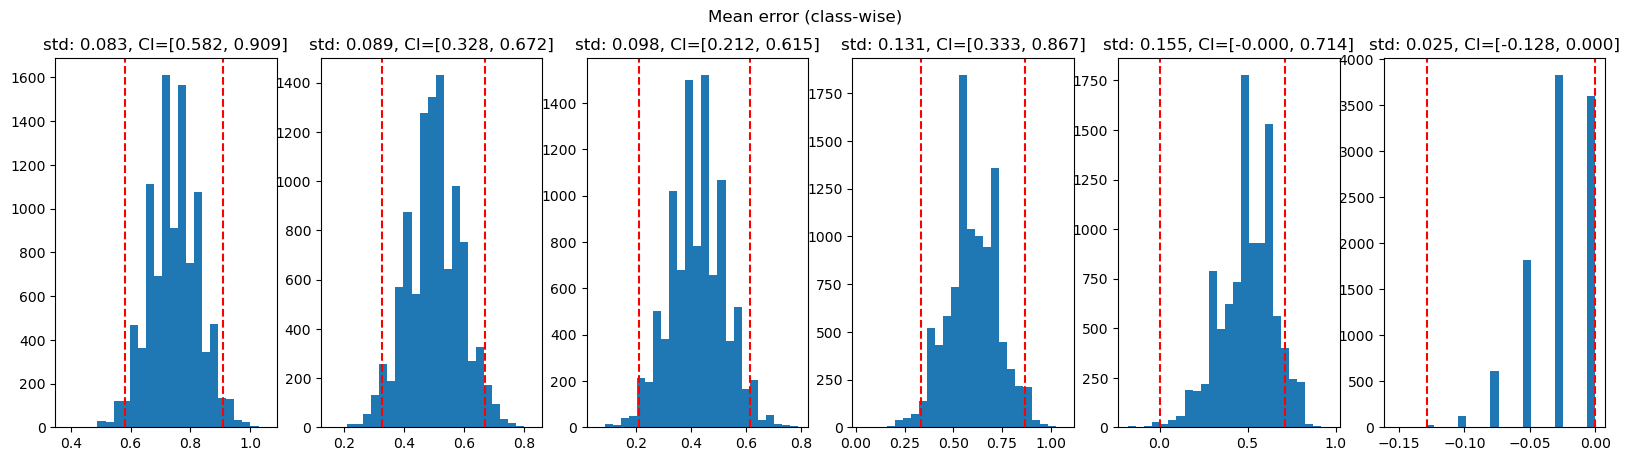

In [48]:
fig, ax = plt.subplots(1, 6)
fig.set_figwidth(20)
fig.suptitle("Mean error (class-wise)")
for i in range(6):
    idx = np.where(asa_mapped_common == i / 5)
    res = bootstrap(idx, severity_diff, confidence_level=0.95, random_state=rng)
    ci_low, ci_high = res.confidence_interval
    ax[i].hist(res.bootstrap_distribution, bins=25)
    ax[i].title.set_text(f"std: {res.standard_error:.3f}, CI=[{ci_low:.3f}, {ci_high:.3f}]")
    ax[i].axvline(ci_low, color="r", ls="--")
    ax[i].axvline(ci_high, color="r", ls="--")

In [22]:
import numpy as np


def map_severity(severity):
    mp = {
        0.0: 52.25,
        0.2: 110.0,
        0.4: 152.5,
        0.6: 197.5,
        0.8: 240,
        1.0: 272.75
    }
    return mp[severity]


severity_mapped_common = np.vectorize(map_severity, otypes=[float])(severity_common)

In [23]:
asa_descaled_common = asa[common_ids] * 285.5 + 14.5
# severity_mapped_common = pd.Series(severity_mapped)
# severity_mapped_common.index = asa.index
# severity_mapped_common = severity_mapped_common[common_ids]

asa_descaled_common = asa_descaled_common.to_numpy()
# severity_mapped_common = severity_mapped_common.to_numpy()

In [24]:
asa_descaled_common.shape

(268,)

Text(0.5, 1.0, 'ASA')

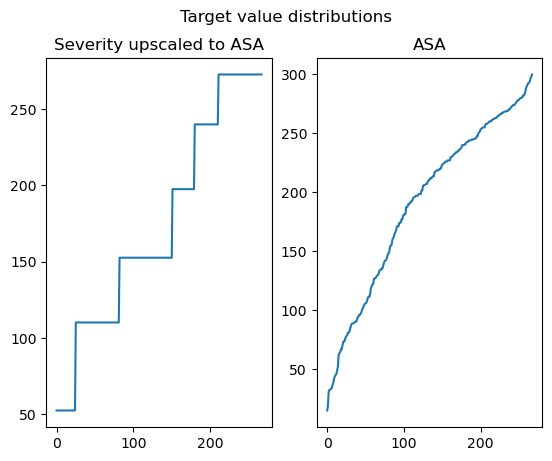

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Target value distributions")
ax1.plot(np.sort(severity_mapped_common))
ax1.set_title("Severity upscaled to ASA")
ax2.plot(np.sort(asa_descaled_common))
ax2.set_title("ASA")

In [26]:
def asa_diff(idx):
    return np.mean(np.abs(severity_mapped_common[idx] - asa_descaled_common[idx]))

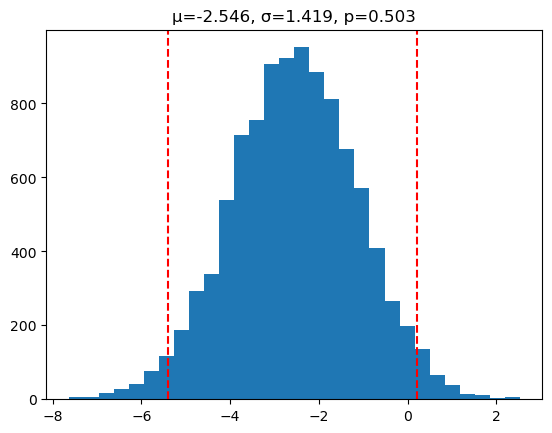

In [69]:
draw_bs(severity_mapped_common, asa_descaled_common)l

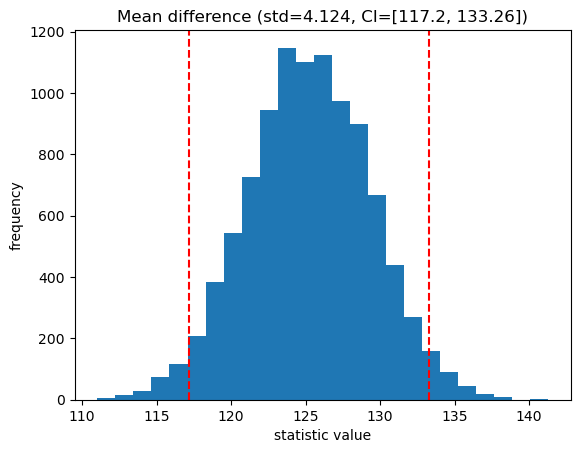

In [42]:
rng = np.random.default_rng()
idx = np.arange(asa_descaled_common.shape[0])

res = bootstrap((idx,), asa_diff, confidence_level=0.95, random_state=rng)
ci_low, ci_high = res.confidence_interval

fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title(f'Mean difference (std={res.standard_error:.3f}, CI=[{ci_low:.1f}, {ci_high:.2f}])')
ax.axvline(ci_low, color="r", ls="--")
ax.axvline(ci_high, color="r", ls="--")
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

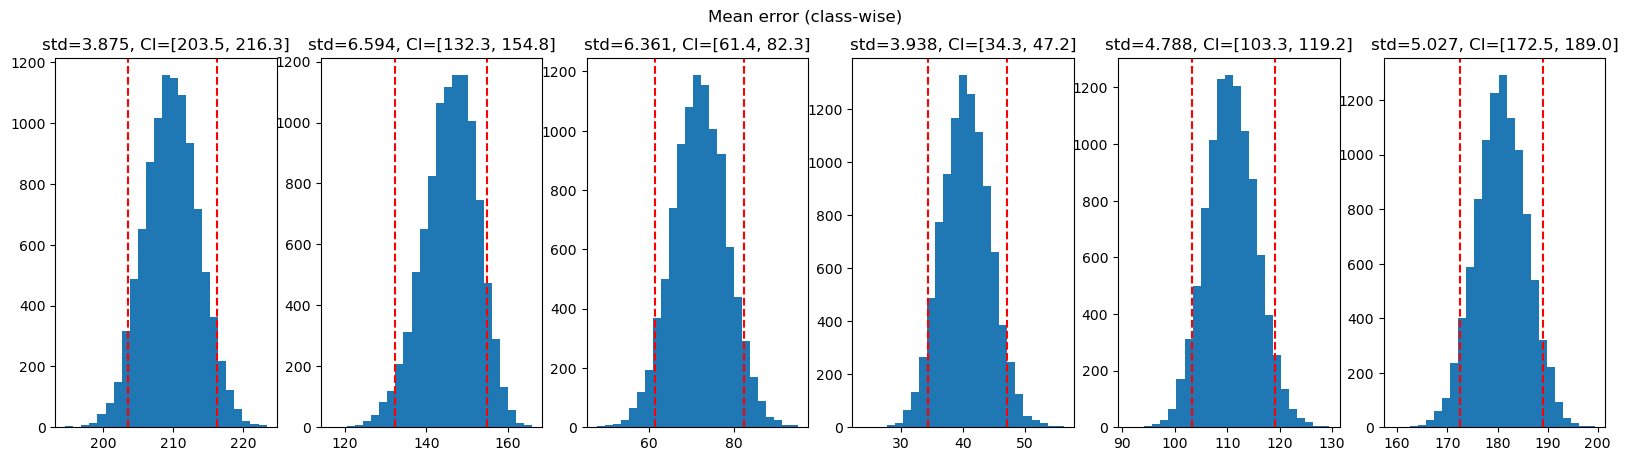

In [43]:
fig, ax = plt.subplots(1, 6)
fig.set_figwidth(20)
fig.suptitle("Mean error (class-wise)")

asa_bounds = [0.0, 90, 130, 175, 220, 260, 300]

for i in range(6):
    idx = np.intersect1d(np.where(asa_bounds[i] < asa_descaled_common), np.where(asa_descaled_common <= asa_bounds[i + 1]))
    res = bootstrap((idx,), asa_diff, confidence_level=0.9, random_state=rng)
    ci_low, ci_high = res.confidence_interval
    ax[i].hist(res.bootstrap_distribution, bins=25)
    ax[i].title.set_text(f"std={res.standard_error:.3f}, CI=[{ci_low:.1f}, {ci_high:.1f}]")
    ax[i].axvline(ci_low, color="r", ls="--")
    ax[i].axvline(ci_high, color="r", ls="--")
